In [1]:
import pandas as pd
import numpy as np
# Read the CSV file
df = pd.read_csv('C:\\Users\\37424\\Desktop\\simulated_transaction_2024.csv')
pd.set_option('display.float_format', lambda x: '%.0f' % x)
# print(df.head().to_string(index=False))

C:\Users\37424\AppData\Local\Temp\ipykernel_20220\2580251088.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Check for any missing values
print(df.isnull().sum())

Date                         229
Timestamp                    251
Account No                   224
Balance                      246
Amount                       209
Third Party Account No    223764
Third Party Name            7079
dtype: int64


In [3]:
# # Replace empty strings with NaN
# df['Date'].replace('', pd.NA, inplace=True)
#
# # Find the index of the first row with a missing 'Date'
# first_missing_date_index = df[df['Date'].isnull()].index.min()
#
# # Get the row with the first missing 'Date'
# if pd.notna(first_missing_date_index):
#     first_missing_date_row = df.loc[first_missing_date_index]
# else:
#     first_missing_date_row = "No missing Date found"
#
# # Display the row with the first missing 'Date'
# print(first_missing_date_row)

In [4]:
# Define the condition for rows to drop
condition = (
    df['Date'].isnull() |
    df['Timestamp'].isnull() |
    df['Account No'].isnull() |
    df['Balance'].isnull() |
    df['Amount'].isnull() |
    (df['Third Party Account No'].isnull() & df['Third Party Name'].isnull())
)

# Invert the condition to keep rows where the condition is False
df_cleaned = df[~condition]
print(df_cleaned.head().to_string(index=False))
df_cleaned.to_csv('New_dataset_clean.csv', index=False)

      Date Timestamp  Account No  Balance  Amount  Third Party Account No   Third Party Name
01/01/2023     00:00   678330503     2971    1584                     NaN Westport Care Home
01/01/2023     00:00   472213568     3792    1950                     NaN   Barbiee Boutique
01/01/2023     00:00   472213568     3012    -780               283027736                NaN
01/01/2023     00:00   283027736     1787     780               472213568                NaN
01/01/2023     00:00   624500124     3226    1825                     NaN           Fat Face


In [5]:
print(df_cleaned.isnull().sum())

Date                           0
Timestamp                      0
Account No                     0
Balance                        0
Amount                         0
Third Party Account No    222389
Third Party Name            6805
dtype: int64


In [6]:
unique_account_nos = df_cleaned['Account No'].nunique()
print(f"Unique Account Nos: {unique_account_nos}")

unique_third_party_names = df_cleaned['Third Party Name'].replace('', np.nan).nunique()
print(f"Unique Third Party Names: {unique_third_party_names}")

Unique Account Nos: 976
Unique Third Party Names: 83


In [7]:
df_cleaned = df_cleaned.copy()
# Convert the 'Date' and 'Timestamp' columns to a single datetime column
df_cleaned['Datetime'] = pd.to_datetime(df_cleaned['Date'] + ' ' + df_cleaned['Timestamp'], format="%d/%m/%Y %H:%M")

# Sort the data by 'Account No' and 'Datetime'
sorted_data = df_cleaned.sort_values(by=['Account No', 'Datetime'])
sorted_data = sorted_data.drop(columns=['Date', 'Timestamp'])
print(sorted_data.head(1000).to_string(index=False))
sorted_data.to_csv('New_dataset_Account_with_datetime.csv', index=False)


 Account No  Balance  Amount  Third Party Account No  Third Party Name            Datetime
  101531259      124    -859                     NaN               LBG 2023-01-01 00:00:00
  101531259      116      -8                     NaN            Disney 2023-01-01 00:00:00
  101531259       16    -100                     NaN   Grand Union BJJ 2023-01-01 00:00:00
  101531259      -64     -80                     NaN           Matalan 2023-01-01 09:37:00
  101531259     -248    -184                     NaN           Matalan 2023-01-01 12:00:00
  101531259     -446    -198                     NaN           Topshop 2023-01-01 12:28:00
  101531259     -550    -104                     NaN           Matalan 2023-01-01 15:54:00
  101531259     -650    -100                     NaN           Topshop 2023-01-01 16:28:00
  101531259     -778    -128                     NaN           Matalan 2023-01-01 16:52:00
  101531259     -872     -93                     NaN             Tesco 2023-01-07 08:38:00

In [8]:
sorted_data_with_acc = sorted_data.dropna(subset=['Third Party Account No'])
print(sorted_data_with_acc.head(1000).to_string(index=False))
sorted_data_with_acc.to_csv('New_dataset_Account_with_Account.csv', index=False)

 Account No  Balance  Amount  Third Party Account No Third Party Name            Datetime
  104832000     2385    -670               587923845              NaN 2023-01-01 00:00:00
  104832000     1072    -670               587923845              NaN 2023-01-31 23:59:00
  104832000       51     290               587923845              NaN 2023-02-15 06:57:00
  104832000      600    -670               587923845              NaN 2023-02-28 23:59:00
  104832000      128    -670               587923845              NaN 2023-03-31 23:59:00
  104832000     -370    -670               587923845              NaN 2023-04-30 23:59:00
  104832000    -1212     160               587923845              NaN 2023-05-02 12:18:00
  104832000     -734    -670               587923845              NaN 2023-05-31 23:59:00
  104832000     -999    -670               587923845              NaN 2023-06-30 23:59:00
  104832000    -1229    -670               587923845              NaN 2023-07-31 23:59:00
  10483200

In [9]:
#Determine transaction type (expenditure or income)
sorted_data['Transaction Type'] = sorted_data['Amount'].apply(lambda x: 'Expense' if x < 0 else 'Income')

#Group by month and account
sorted_data['Month'] = sorted_data['Datetime'].dt.to_period('M')
grouped_data = sorted_data.groupby(['Account No', 'Month'])

monthly_expense = grouped_data['Amount'].agg(lambda x: x[x < 0].sum()).rename('Monthly Expense')
monthly_income = grouped_data['Amount'].agg(lambda x: x[x > 0].sum()).rename('Monthly Income')
monthly_balance = grouped_data['Balance'].agg('last').rename('End of Month Balance')

#Merge Results
monthly_summary = pd.concat([monthly_expense, monthly_income, monthly_balance], axis=1)
monthly_summary.columns = ['Monthly Expense', 'Monthly Income', 'End of Month Balance']
monthly_summary.reset_index(inplace=True)

print(monthly_summary.head(1000).to_string(index=False))
monthly_summary.to_csv('New_dataset_Account_monthly_summary.csv', index=False)

 Account No   Month  Monthly Expense  Monthly Income  End of Month Balance
  101531259 2023-01            -2241            1542                  -575
  101531259 2023-02            -1223            1542                  -311
  101531259 2023-03            -1146            1542                    85
  101531259 2023-04            -1411            1542                   217
  101531259 2023-05            -1369            1542                   390
  101531259 2023-06            -1881            1542                    13
  101531259 2023-07            -1221            1542                   334
  101531259 2023-08            -1854            1542                    22
  101531259 2023-09            -1251            1542                   314
  101531259 2023-10            -1771            1542                    85
  101531259 2023-11            -1239            1542                   389
  101531259 2023-12            -1020               0                   228
  104832000 2023-01      

In [10]:
sorted_data['Year'] = sorted_data['Datetime'].dt.year

grouped_data = sorted_data.groupby(['Account No', 'Year'])

annual_expense = grouped_data['Amount'].apply(lambda x: x[x < 0].sum()).rename('Annual Expense')
annual_income = grouped_data['Amount'].apply(lambda x: x[x > 0].sum()).rename('Annual Income')

annual_balance = grouped_data['Balance'].apply(lambda x: x.iloc[-1]).rename('End of Year Balance')

annual_summary = pd.concat([annual_expense, annual_income, annual_balance], axis=1).reset_index()
print(annual_summary.head(1000).to_string(index=False))
annual_summary.to_csv('New_dataset_Account_annual_summary.csv', index=False)

 Account No  Year  Annual Expense  Annual Income  End of Year Balance
  101531259  2023          -17628          16968                  228
  104832000  2023          -25116          20550                -3186
  105375973  2023          -10067           9000                  509
  106601471  2023           -7760          18425                11920
  108481285  2023          -15062          25104                10704
  108563213  2023          -16494          41239                26334
  108812033  2023           -9641           9130                  717
  108931112  2023          -38492          53519                16503
  111137699  2023          -21787          20100                  -80
  113747882  2023          -16187          28425                13639
  116169597  2023          -17933          19218                 1790
  116598243  2023          -21076          22872                 3634
  117273481  2023          -26986          37136                10922
  117308635  2023   

In [12]:
df_with_third_party = sorted_data.dropna(subset=['Third Party Name'])
df_with_third_party.loc[:,'Transaction Type'] = df_with_third_party['Amount'].apply(lambda x: 'Expense' if x > 0 else 'Income')

# Group by 'Third Party Name' and sort within each group by 'Datetime'
grouped = df_with_third_party.groupby('Third Party Name').apply(lambda x: x.sort_values('Datetime'))

# Resetting index to get a clean dataframe
grouped = grouped.reset_index(drop=True)

# Reorder columns to have 'Third Party Name' as the first column
cols = grouped.columns.tolist()
cols.insert(0, cols.pop(cols.index('Third Party Name')))
grouped = grouped[cols]

# Remove 'Third Party Account No', 'Month' and 'Year' columns
columns_to_drop = ['Third Party Account No', 'Month', 'Year']
grouped = grouped.drop(columns_to_drop, axis=1)
# Displaying the sorted dataframe
print(grouped.head(3000).to_string(index=False))
grouped.to_csv('New_dataset_Merchant_corresponding_user_details.csv', index=False)

C:\Users\37424\AppData\Local\Temp\ipykernel_20220\1645869886.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_with_third_party.groupby('Third Party Name').apply(lambda x: x.sort_values('Datetime'))


Third Party Name  Account No  Balance  Amount            Datetime Transaction Type
     A Cut Above   285873880     3818    1950 2023-01-01 00:00:00          Expense
     A Cut Above   137822385     3625    2773 2023-01-01 00:00:00          Expense
     A Cut Above   768271776     3620    1950 2023-01-01 00:00:00          Expense
     A Cut Above   873701090     2357    1544 2023-01-01 00:00:00          Expense
     A Cut Above   865748375     4607    2773 2023-01-01 00:00:00          Expense
     A Cut Above   691789577     2533    2021 2023-01-01 00:00:00          Expense
     A Cut Above   819515373     3802    2021 2023-01-01 00:00:00          Expense
     A Cut Above   834383043     3939    2021 2023-01-01 00:00:00          Expense
     A Cut Above   675398089     1948    1244 2023-01-01 00:00:00          Expense
     A Cut Above   170637730     3178    2021 2023-01-01 00:00:00          Expense
     A Cut Above   768271776     2267    1950 2023-02-01 00:00:00          Expense
    

In [13]:
grouped2 = grouped[grouped['Transaction Type'] == 'Income']
print(grouped2.head(1000).to_string(index=False))
grouped2.to_csv('New_dataset_Merchant_corresponding_incomes.csv', index=False)

Third Party Name  Account No  Balance  Amount            Datetime Transaction Type
     A Cut Above   104832000    -2441    -200 2023-08-08 15:37:00           Income
    A Yarn Story   969804197      814     -44 2023-01-01 12:19:00           Income
    A Yarn Story   441142605     1182      -8 2023-01-02 09:38:00           Income
    A Yarn Story   687135796     1059     -27 2023-01-04 11:15:00           Income
    A Yarn Story   263882093      440     -38 2023-01-04 15:17:00           Income
    A Yarn Story   441142605     1120      -6 2023-01-04 16:17:00           Income
    A Yarn Story   496674181      534      -6 2023-01-05 17:42:00           Income
    A Yarn Story   993039226       85     -36 2023-01-06 16:23:00           Income
    A Yarn Story   822135975     3692      -3 2023-01-08 11:07:00           Income
    A Yarn Story   993039226      -19     -72 2023-01-09 16:04:00           Income
    A Yarn Story   699139822     2469     -48 2023-01-11 09:28:00           Income
    

In [20]:
current_date = grouped2['Datetime'].max()

rfm = grouped2.groupby(['Third Party Name', 'Account No']).agg({
    'Datetime': lambda x: (current_date - x.max()).days,  # Recency
    'Account No': 'count',                                        # Frequency
    'Amount': lambda x: -x.sum()                                    # Monetary
}).rename(columns={
    'Datetime': 'recency',
    'Account No': 'frequency',
    'Amount': 'monetary'
}).reset_index()


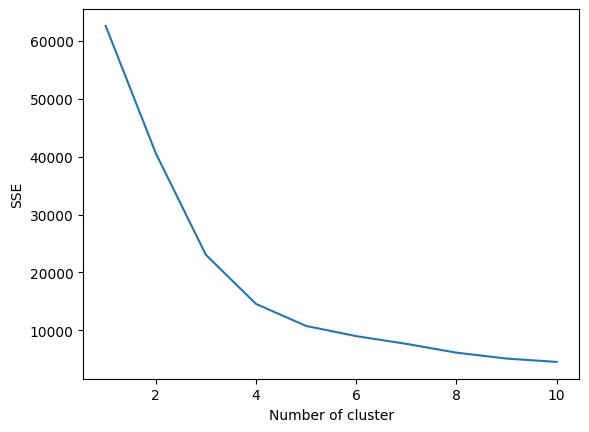

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

#Perform independent clustering analysis on each merchant
# for account in rfm['to_randomly_generated_account'].unique():
#     print(f"Processing account: {account}")

#Filter data for specific merchants
# account_rfm = rfm[rfm['to_randomly_generated_account'] == account]

#Data preprocessing - Standardized RFM values
scaler = StandardScaler()
# rfm_scaled = scaler.fit_transform(account_rfm[['r_score', 'f_score', 'm_score']])
rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])
#Initialize SSE dictionary to store SSE for each k value
sse = {}

#Use Elbow Method to find the optimal K value and test K values from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_  # 存储SSE (Sum of Squared Errors)

#Draw a graph of SSE changing with k value
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
# plt.xlabel(f"Number of cluster for account {account}")
plt.xlabel(f"Number of cluster")
plt.ylabel("SSE")
plt.show()

#Select the optimal K value based on the graph
#
# k_opt = 3  #This value is the inflection point value in the elbow diagram
#
# #Applying K-Means clustering
# kmeans = KMeans(n_clusters=k_opt, random_state=42)
# clusters = kmeans.fit_predict(rfm_scaled)
# rfm['Cluster'] = clusters
#
# rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [23]:
filtered_df = grouped2[
    (grouped2['Account No'] ==  366550080) &
    (grouped2['Third Party Name'] == 'A Yarn Story')
]

# Now we can calculate the total money spent, the number of visits, and the date of the last visit.
total_money_spent = -filtered_df['Amount'].sum()
number_of_visits = filtered_df.shape[0]
date_of_last_visit = filtered_df['Datetime'].max()

total_money_spent, number_of_visits, date_of_last_visit

(-402.01, 8, Timestamp('2023-10-30 09:31:00'))